In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
 99%|██████████████████████████████████████▌| 1.96G/1.98G [00:08<00:00, 270MB/s]
100%|███████████████████████████████████████| 1.98G/1.98G [00:08<00:00, 244MB/s]


In [ ]:
!unzip fruit-and-vegetable-image-recognition.zip

In [3]:
train_dir='/kaggle/working/train'
test_dir='/kaggle/working/test'
valid_dir='/kaggle/working/validation'

In [32]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image
import time
from sklearn.metrics import classification_report
import torch.nn.functional as F
import seaborn as sns 
from sklearn.metrics import confusion_matrix

In [33]:
BATCH_SIZE=64
EPOCHS=20
num_classes=36

In [6]:
train_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.RandomCrop((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])

])


test_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.CenterCrop((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [7]:
train_dataset=torchvision.datasets.ImageFolder(train_dir,transform=train_transform)

test_dataset=torchvision.datasets.ImageFolder(test_dir,transform=test_transform)

valid_dataset=torchvision.datasets.ImageFolder(valid_dir,transform=test_transform)

In [8]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)

test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

valid_loader=torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [9]:
class VGG16 (nn.Module):
  def __init__ (self,num_classes):
    super().__init__()

    self.block1=nn.Sequential(
        nn.Conv2d(3,64,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    )


    self.block2=nn.Sequential(
        nn.Conv2d(64,128,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    )


    self.block3=nn.Sequential(
        nn.Conv2d(128,256,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    )


    self.block4=nn.Sequential(
        nn.Conv2d(256,512,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    )

    self.block5=nn.Sequential(
        nn.Conv2d(512,512,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=(3,3),stride=(1,1),padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    )

    self.classifier=nn.Sequential(
        nn.Linear(512*7*7,4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096,4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096,num_classes)
    )

#     for m in self.modules():
#       if isinstance(m,nn.Conv2d) or isinstance(m, nn.Linear):
#         nn.init.kaiming_uniform_(m.weight,mode='fan_in',nonlinearity='relu')
#         if m.bias is not None:
#           m.bias.detach().zero_()


  def forward(self, x):
    x=self.block1(x)
    x=self.block2(x)
    x=self.block3(x)
    x=self.block4(x)
    x=self.block5(x)
    x=x.view(x.size(0),-1)
    x=self.classifier(x)
    return x

In [10]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=VGG16(36).to(device)

optimizer=optim.Adam(model.parameters(),lr=0.0001)

criterion=nn.CrossEntropyLoss()

In [11]:
def accuracy(outputs,labels):
  _,predicted=torch.max(outputs,1)
  correct=(predicted==labels).sum().item()
  total=labels.size(0)
  return correct/total


def compute_accuracy(model,data_loader):
  model.eval()
  correct=0
  total=0
  with torch.no_grad():
    for inputs,labels in data_loader:
      inputs,labels=inputs.to(device),labels.to(device)
      outputs=model(inputs)
      _,predicted=torch.max(outputs,1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()
  return correct/total


def train (model,train_loader,optimizer,criterion):
  model.train()
  running_loss=0.0
  for inputs,labels in train_loader:
    inputs,labels=inputs.to(device),labels.to(device)
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * inputs.size(0)

  return running_loss/len(train_loader.dataset)


def validate(model,valid_loader,criterion):
  model.eval()
  running_loss=0.0
  with torch.no_grad():
    for inputs,labels in valid_loader:
      inputs,labels=inputs.to(device),labels.to(device)
      outputs=model(inputs)
      loss=criterion(outputs,labels)
      running_loss += loss.item() * inputs.size(0)

  return running_loss/len(valid_loader.dataset)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20,Train Loss: 3.5844,Valid Loss: 3.5838,Train Accuracy: 0.0318,Valid Accuracy: 0.0285,/nTime taken for Epoch:314.87 seconds
Epoch 2/20,Train Loss: 3.5829,Valid Loss: 3.5841,Train Accuracy: 0.0321,Valid Accuracy: 0.0285,/nTime taken for Epoch:306.44 seconds
Epoch 3/20,Train Loss: 3.5439,Valid Loss: 3.4609,Train Accuracy: 0.0526,Valid Accuracy: 0.0570,/nTime taken for Epoch:306.27 seconds
Epoch 4/20,Train Loss: 3.3191,Valid Loss: 3.2122,Train Accuracy: 0.0851,Valid Accuracy: 0.0769,/nTime taken for Epoch:306.98 seconds
Epoch 5/20,Train Loss: 3.1736,Valid Loss: 2.9472,Train Accuracy: 0.1178,Valid Accuracy: 0.1368,/nTime taken for Epoch:307.40 seconds
Epoch 6/20,Train Loss: 3.0662,Valid Loss: 2.8032,Train Accuracy: 0.1409,Valid Accuracy: 0.1624,/nTime taken for Epoch:307.24 seconds
Epoch 7/20,Train Loss: 2.9823,Valid Loss: 2.6473,Train Accuracy: 0.1897,Valid Accuracy: 0.2336,/nTime taken for Epoch:306.54 seconds
Epoch 8/20,Train Loss: 2.7828,Valid Loss: 2.3152,Train Accuracy: 0.20

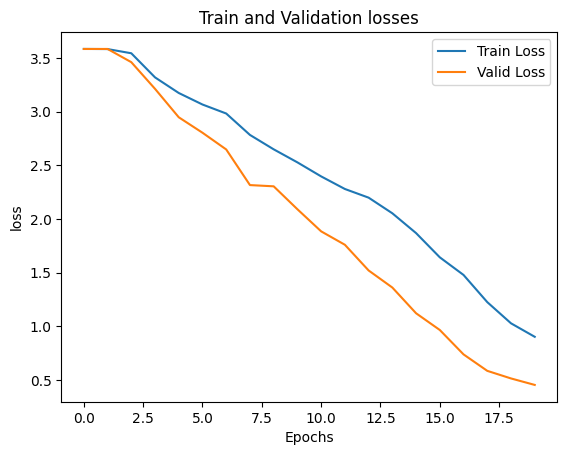

In [12]:
train_losses=[]
valid_losses=[]


for epoch in range(EPOCHS):
  start_time=time.time()
  train_loss=train(model,train_loader,optimizer,criterion)
  valid_loss=validate(model,valid_loader,criterion)
  train_accuracy=compute_accuracy(model,train_loader)
  valid_accuracy=compute_accuracy(model,valid_loader)

  end_time=time.time()
  epoch_time=end_time-start_time

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  tqdm.write(f'Epoch {epoch+1}/{EPOCHS},'
             f'Train Loss: {train_loss:.4f},'
             f'Valid Loss: {valid_loss:.4f},'
             f'Train Accuracy: {train_accuracy:.4f},'
             f'Valid Accuracy: {valid_accuracy:.4f},/n'
             f'Time taken for Epoch:{epoch_time:.2f} seconds'

  )


plt.plot(train_losses,label='Train Loss')
plt.plot(valid_losses,label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Train and Validation losses')
plt.legend()
plt.show()

In [13]:

def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions


In [14]:
test_predictions=predict(model,test_loader)
acc=accuracy_score(test_dataset.targets,test_predictions)
print(acc)

0.9052924791086351


In [ ]:
class_label_map = train_dataset.class_to_idx

for class_name, label in class_label_map.items():
    print(f"Class: {class_name}, and its label: {label}")

In [23]:
classes_names = test_dataset.classes

In [24]:
classes_names

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [30]:
model.eval()

true_labels=[]
predicted_labels=[]

with torch.no_grad():
    for inputs,labels in test_loader:
        inputs=inputs.to(device)
        labels=labels.to(device)
        
        outputs=model(inputs)
        probs=F.softmax(outputs,dim=1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(np.argmax(probs.cpu().numpy(), axis=1))
        
        

test_report=classification_report(true_labels,predicted_labels,target_names=test_dataset.classes)

print(test_report)

               precision    recall  f1-score   support

        apple       0.88      0.70      0.78        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.71      1.00      0.83        10
      cabbage       1.00      0.90      0.95        10
     capsicum       1.00      0.80      0.89        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      0.80      0.89        10
         corn       0.90      0.90      0.90        10
     cucumber       0.91      1.00      0.95        10
     eggplant       1.00      1.00      1.00        10
       garlic       0.91      1.00      0.95        10
       ginger       0.80      0.40      0.53        10
       grapes       1.00      0.90      0.95        10
     jalepeno       1.00      0.70      0.82        10
         kiwi       1.00      0.90      0.95        10
        l

<function matplotlib.pyplot.show(close=None, block=None)>

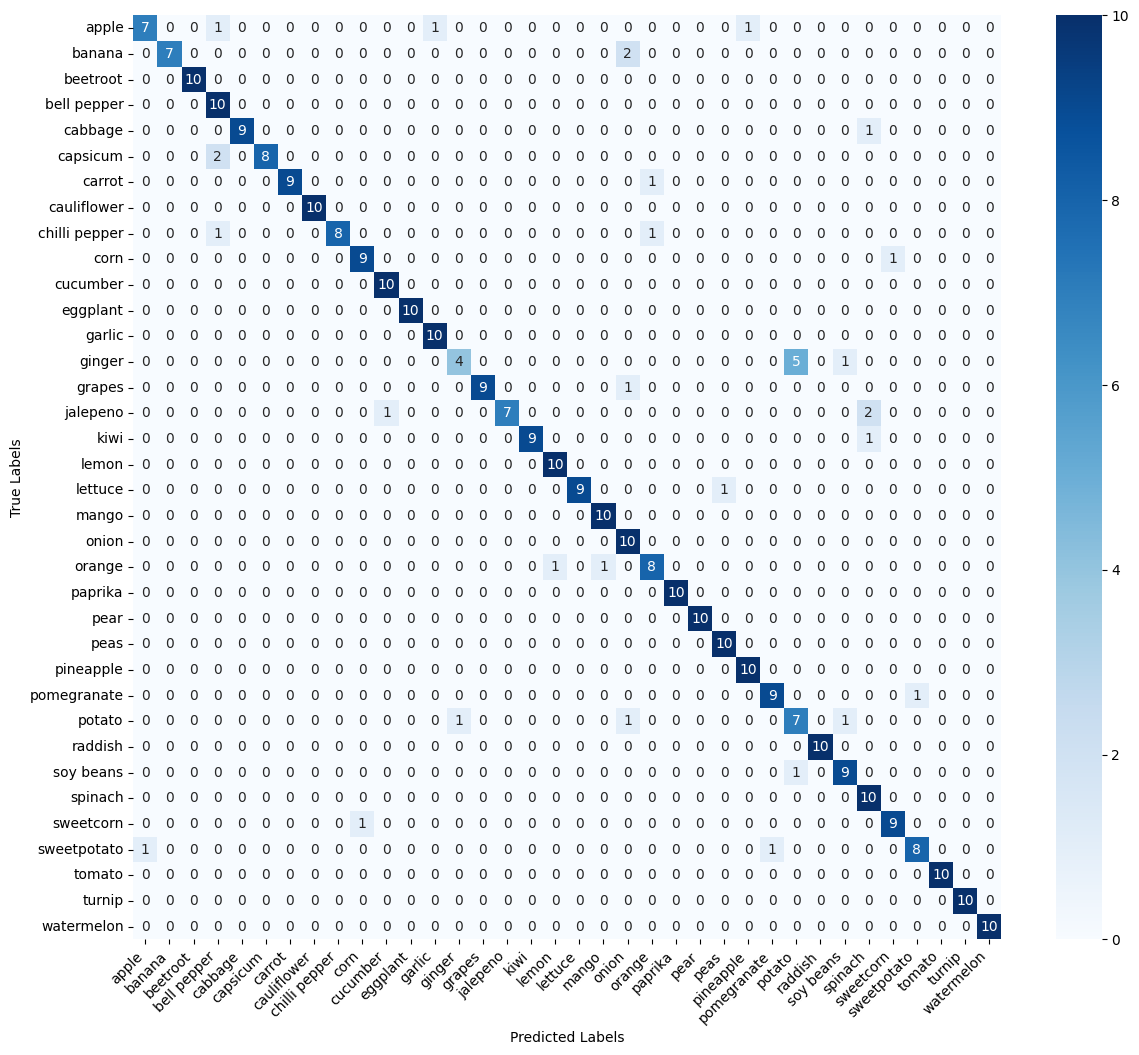

In [37]:
conf_matrix=confusion_matrix(true_labels,predicted_labels)

cmap=plt.cm.Blues
plt.figure(figsize=(14,12))

sns.heatmap(conf_matrix,annot=True,fmt='d',cmap=cmap, xticklabels=test_dataset.classes,yticklabels=test_dataset.classes)

plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)

# plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show